In [1]:
import pandas as pd
import numpy as np
import pystan
import matplotlib.pyplot as plt


In [2]:
## Load and prepare data:

data = pd.read_csv('https://raw.githubusercontent.com/carlson9/KocPython2020/master/Homework/trend2.csv')
data = data.dropna()
print(data)

            country  year    church2             cc  gini_net     rgdpl
0         Australia  1965  26.182790      Australia  29.16514  15.23929
2         Australia  1967  24.744380      Australia  29.50664  16.25018
14        Australia  1979   4.442971      Australia  25.75894  21.58357
16        Australia  1981  27.626460      Australia  28.10000  22.46979
19        Australia  1984  18.099700      Australia  28.80875  23.45019
...             ...   ...        ...            ...       ...       ...
1017  United States  2003  31.000000  United States  37.16354  39.79302
1018  United States  2004  25.051880  United States  37.20000  40.91001
1019  United States  2005  31.425200  United States  37.08701  42.53482
1020  United States  2006  29.700130  United States  36.87890  43.25840
1022  United States  2008  26.678190  United States  36.02488  43.34071

[588 rows x 6 columns]


In [3]:
# create Matrix for X values [1 gini_net. rgdpl]
arr = data.to_numpy()
X_values = np.delete(arr, np.s_[:4], 1)
coefficients = np.concatenate((np.ones((588,1)), X_values), axis = 1)

In [4]:
# Lookup table (dict) for each unique Country, for indexing.
data.country = data.country.str.strip()
inc_countries = data.country.unique() #all included countries
# Lookup table (dict) for each unique Year, for indexing.
inc_years = data.year.unique() #all included countries
#print(inc_countries)
countries = len(inc_countries)

In [5]:
# Create local copies of variables
country_lookup = dict(zip(inc_countries, range(len(inc_countries))))
country = data['country_code'] = data.country.replace(country_lookup).values
year_lookup = dict(zip(inc_years, range(len(inc_years))))
year = data['year_code'] = data.year.replace(year_lookup).values

religiosity = data.church2

In [6]:
coefficients = np.array(coefficients, dtype = float)

In [7]:
varying_intercept_data = {'N': len(religiosity),
                          'J': len(inc_countries),
                          'K': len(inc_years),
                          'country': country+1, # Stan counts starting at 1
                          'year': year+1, # Stan counts starting at 1    
                          'x': coefficients,
                          'y': religiosity}

In [8]:
#print(varying_intercept_data)

In [9]:
# noninformative prior

varying_intercept_non_inf = """
data {
  int<lower=0> N; 
  int<lower=0> J; 
  int<lower=0> K;
  int<lower=1,upper=J> country[N];
  int<lower=1,upper=K> year[N];
  matrix[N,3] x;
  vector[N] y;
} 
parameters {  
  vector[J] a;
  vector[K] a1;
  vector[3] b;
  real mu_a;
  real mu_a1;
  real<lower=0,upper=100> sigma_a;
  real<lower=0,upper=100> sigma_a1;
  real<lower=0,upper=100> sigma_y;
} 
transformed parameters {
  vector[N] y_hat;
  for (i in 1:N)
    y_hat[i] = a[country[i]] + a1[year[i]] + x[i, 1:3] * b;
}
model {
  sigma_a ~ uniform(0, 100);
  sigma_a1 ~ uniform(0, 100);
  mu_a ~ normal(0, 1);
  mu_a1 ~ normal(0, 1);
  a ~ normal (mu_a, sigma_a);
  a1 ~ normal (mu_a1, sigma_a1);
  b ~ normal (0, 1);
  sigma_y ~ uniform(0, 100);
  y ~ normal(y_hat, sigma_y);  
}
"""

vini = pystan.StanModel(model_code=varying_intercept_non_inf)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3b32a033981d3d0a99db2acda41c219a NOW.


In [10]:
varying_intercept_fit_non_inf = vini.sampling(data=varying_intercept_data, iter=1000, chains=2, control = {'max_treedepth':20})

In [11]:
a_sample_fit_non_inf = pd.DataFrame(varying_intercept_fit_non_inf['a'])

In [12]:
print(varying_intercept_fit_non_inf)

Inference for Stan model: anon_model_3b32a033981d3d0a99db2acda41c219a.
2 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=1000.

             mean se_mean     sd   2.5%    25%    50%     75%   97.5%  n_eff   Rhat
a[1]         4.85    0.22   2.63  -0.33   3.22    4.8    6.44   10.38    139   1.01
a[2]         9.97    0.22   2.52    5.3   8.39   9.91   11.54   14.97    137   1.01
a[3]         7.74    0.19   2.27   3.56   6.19   7.64    9.23   12.56    142   1.01
a[4]        -12.4    0.22   2.81 -18.23 -14.27 -12.33  -10.45   -7.12    158   1.02
a[5]         14.9    0.23   2.89    9.1  13.21  14.92   16.75   20.87    161   1.01
a[6]        -9.75    0.33   4.12 -17.86 -12.64  -9.62   -6.95   -1.71    152   1.03
a[7]         0.28    0.22    3.0  -5.45  -1.77   0.29    2.26    6.35    189   1.01
a[8]        -4.11    0.18    2.4  -8.95  -5.77  -3.99   -2.49    0.59    181   1.01
a[9]        -4.13    0.19   2.23  -8.47  -5.55  -4.15   -

In [13]:
import seaborn as sns
sns.set(style="darkgrid", palette="colorblind", color_codes=True)

0.3523561648146803

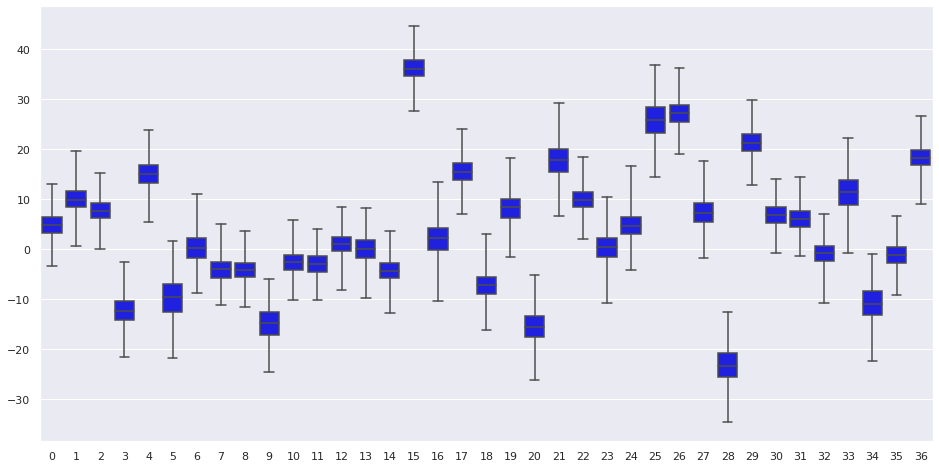

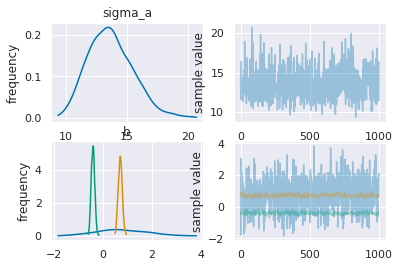

In [14]:
plt.figure(figsize=(16, 8))
sns.boxplot(data=a_sample_fit_non_inf, whis=np.inf, color="blue")

varying_intercept_fit_non_inf.plot(pars=['sigma_a', 'b']);

varying_intercept_fit_non_inf['b'].mean()


In [15]:
# informative prior

varying_intercept_inf = """
data {
  int<lower=0> N; 
  int<lower=0> J; 
  int<lower=0> K;
  int<lower=1,upper=J> country[N];
  int<lower=1,upper=K> year[N];
  matrix[N,3] x;
  vector[N] y;
} 
parameters {  
  vector[J] a;
  vector[K] a1;
  vector[3] b;
  real mu_a;
  real mu_a1;
  real<lower=0,upper=100> sigma_a;
  real<lower=0,upper=100> sigma_a1;
  real<lower=0,upper=100> sigma_y;
} 
transformed parameters {
  vector[N] y_hat;
  for (i in 1:N)
    y_hat[i] = a[country[i]] + a1[year[i]] + x[i, 1:3] * b;
}
model {
  sigma_a ~ uniform(0, 100);
  sigma_a1 ~ uniform(0, 100);
  mu_a ~ normal(0, 1);
  mu_a1 ~ normal(0, 1);
  a ~ normal (mu_a, sigma_a);
  a1 ~ normal (mu_a1, sigma_a1);
  b ~ normal (10, 0.01);
  sigma_y ~ uniform(0, 100);
  y ~ normal(y_hat, sigma_y);  
}
"""

vii = pystan.StanModel(model_code=varying_intercept_inf)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7c766a784cd94fb8994e7898d9b16506 NOW.


In [16]:
varying_intercept_fit_inf = vii.sampling(data=varying_intercept_data, iter=1000, chains=2, control = {'max_treedepth':20})

In [17]:
a_sample_inf = pd.DataFrame(varying_intercept_fit_inf['a'])

In [18]:
print(varying_intercept_fit_inf)

Inference for Stan model: anon_model_7c766a784cd94fb8994e7898d9b16506.
2 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=1000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a[1]       -355.8    1.55  13.31 -382.4 -364.7 -355.1 -347.0 -330.4     74   1.01
a[2]       -313.6    1.39  13.61 -340.0 -323.4 -313.5 -304.6 -288.2     95   1.01
a[3]       -274.4    1.38  13.12 -300.1 -283.5 -274.7 -265.2 -247.3     91   1.01
a[4]        -82.6    1.35  14.51 -111.5 -93.07 -81.86 -73.14 -55.58    116   1.01
a[5]       -330.2    1.34  15.04 -358.3 -340.7 -329.8 -319.7 -301.0    125    1.0
a[6]       -296.7    1.38  15.74 -327.4 -307.2 -296.1 -286.5 -265.8    130   1.01
a[7]       -148.0    1.37   17.4 -181.3 -160.3 -148.2 -135.7 -114.2    161   1.01
a[8]       -150.4    1.45  14.46 -178.4 -160.6 -150.3 -140.7 -121.7    100   1.01
a[9]       -296.8    1.54  12.84 -320.7 -305.2 -296.8 -288.1 -271.7     69 

In [19]:
import seaborn as sns
sns.set(style="darkgrid", palette="colorblind", color_codes=True)

9.996639636339207

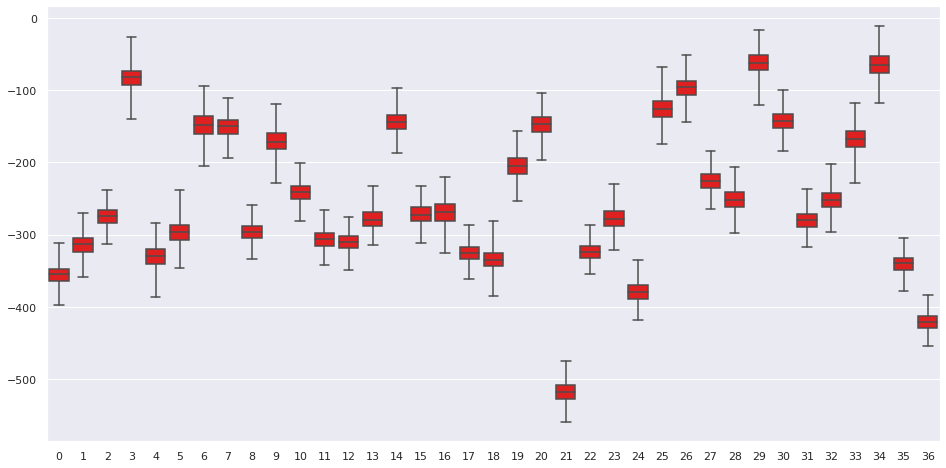

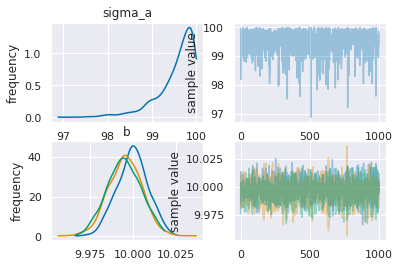

In [20]:

plt.figure(figsize=(16, 8))
sns.boxplot(data=a_sample_inf, whis=np.inf, color="red")

varying_intercept_fit_inf.plot(pars=['sigma_a', 'b']);
varying_intercept_fit_inf['b'].mean()

In [ ]:
#After setting the the highly informayive prior, beta lost in comparison to the first time a lot of varience.
#the highly informative prior made mean of beta swich from 0.3523561648146803 to 9.996639636339207
#the sigma a distribution got also distorted from being around 15 it is now around 100
#these diffrences show, that non representative priors can lead highly dissorted data that could be missinterpreted and does not 
#represent the actual data